In [1]:
# Importing some things to get rid of warnings
import os
nthreads = 1
os.environ["OMP_NUM_THREADS"] = str(nthreads) 
os.environ["OPENBLAS_NUM_THREADS"] = str(nthreads) 
os.environ["MKL_NUM_THREADS"] = str(nthreads)

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")


In [2]:
# The usual suspects

import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.cluster import KMeans

import SP500models as models

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 

In [3]:
from data_pipeline.processing import sharpe_normalize, risk
from data_pipeline.processing import l2_normalization
from data_pipeline.processing import correlation_histogram
from data_pipeline.processing import market_adjust
from data_pipeline.processing import industry_adjust

# Showing a sample of the KPIs on indsutry clusters

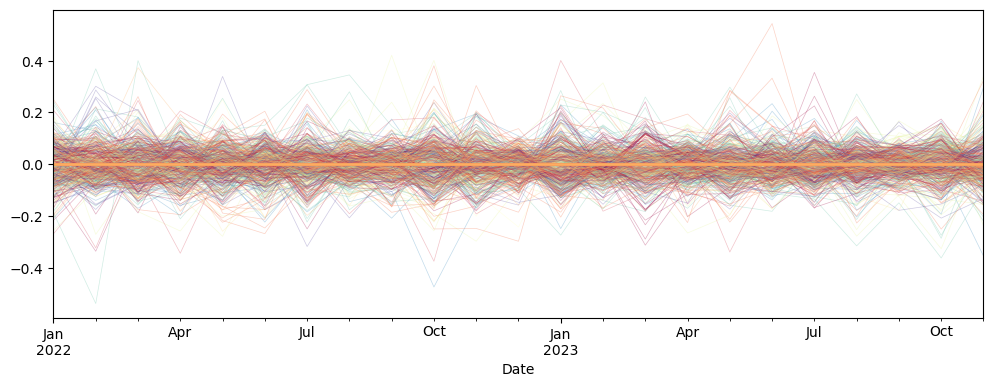

In [77]:
closing_prices = pd.read_pickle("./data/dataframes/closing_prices/closing_prices_monthly.pkl")
# baseline clusters = industry
import pickle
with open('./models/industry_clusters.pkl', 'rb') as handle:
    industry_clusters = pickle.load(handle)

ROR = closing_prices.pct_change().dropna()
data = industry_adjust(market_adjust(ROR), list(industry_clusters.values()))

name_to_num = {name : i for (i, name) in enumerate(set(industry_clusters.values()))}
clusters_dict = {tick : name_to_num[industry_clusters[tick]] for tick in industry_clusters.keys()}
clust_to_tick = {label : [tick for tick in clusters_dict.keys() if clusters_dict[tick] == label] for label in clusters_dict.values()}

fig, ax = plt.subplots(figsize = (12,4))

for i in clust_to_tick.keys():
    color = plt.get_cmap('Spectral')(i/(len(clust_to_tick.keys())-1))
    data[clust_to_tick[i]].plot(legend = False, color = color, ax=ax, alpha = 0.3, linewidth = 0.5)
for i in clust_to_tick.keys():
    color = plt.get_cmap('Spectral')(i/(len(clust_to_tick.keys())-1))
    data[clust_to_tick[i]].mean(axis = 1).plot(legend = False, color = color, ax=ax, alpha = 1, linewidth = 2)

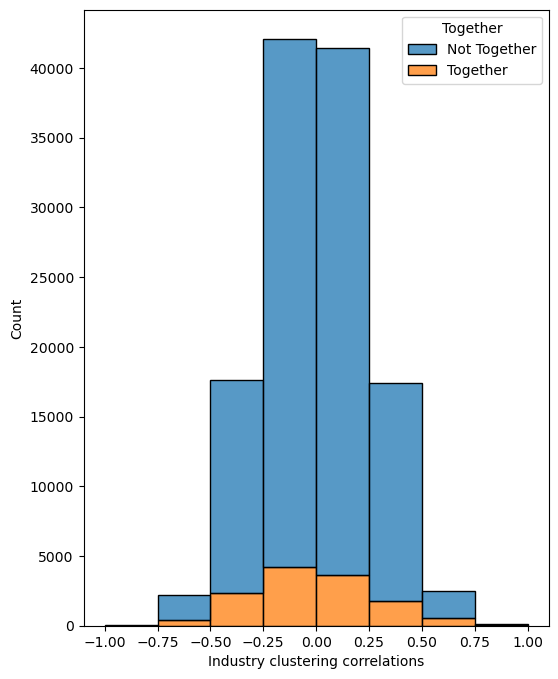

In [80]:
f, ax = plt.subplots(figsize=(6,8))

#axarr[0].set_xlabel("industry clustering correlations for RORs")
ax.set_xlabel("Industry clustering correlations")

#correlation_histogram(data, bins = np.linspace(-1,1,9), clusters = clusters_dict, ax = axarr[0])

correlation_histogram(data, bins = np.linspace(-1,1,9), clusters = clusters_dict, ax = ax)

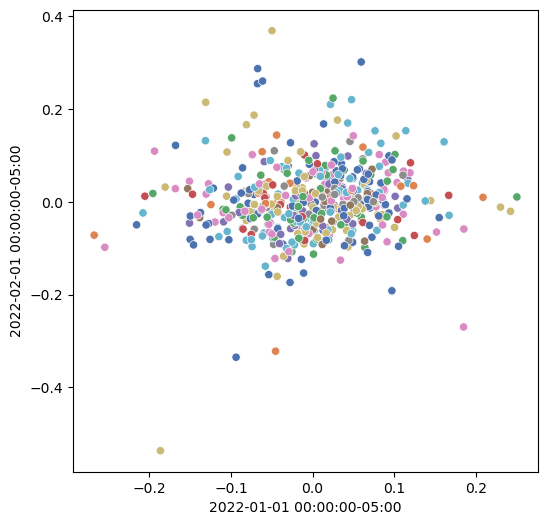

In [6]:
X = data.T
X["cluster"] = list(clusters_dict.values())



cols = X.columns
f, ax = plt.subplots(figsize = (6,6))

sns.scatterplot(data = X, x = cols[0], y = cols[1], hue = 'cluster', palette = 'deep', ax = ax, legend = False)

import plotly.graph_objects as go

fig = go.Figure(data = [go.Scatter3d(
    x = X[cols[0]],
    y = X[cols[1]],
    z = X[cols[2]],
    mode = 'markers',
    marker = dict(
        size = 4,
        color = X['cluster'],
        colorscale = 'spectral',
        opacity = 0.8
    )
)])

fig.update_layout(
    title = "3D visualization of clusters",
    scene = dict(
        xaxis_title = "returns 1",
        yaxis_title = "returns 2",
        zaxis_title = "returns 3"
    ),
    margin = dict(l = 0, r = 0, t= 0)
)

fig.show()

# KMeans Clustering class

In [7]:
class KMeans_Clustering_SP500():
    def __init__(self, n_min = 2, n_max = None,  test_size = 7, use_validation = True):

        self.test_size = 7        
        self.scores = {"DaviesBouldin": [], "CalinskiHarabasz": [], "Silhouette": [], "WCSS" : []}
        self.labels = []
        
        self.n_min = n_min
        self.n_max = n_max+1
        
        self.val = use_validation
        
        self.clusters = []

    def magic_score(self, SH,DB,CH):
        #return ((SH+1)/2) * np.arctan(DB)/(np.pi/2) * np.exp(-CH)
        return (SH+1)/2 * (1/(DB + 1) * (CH/(CH + 1)))
        #return ((SH + 1)/2 +  + )
    # the fit function behaves almost exactly like the usual scikit learn models.

    def fit(self, data):
        self.X = data
        
        # If no maximum clusters given, use the data
        if self.n_max == None:
            self.n_max = len(self.X.columns) - 1
        
        # doing the train-test split
        if self.val == True:
            self.X_train = self.X.iloc[:-self.test_size, :]
            self.X_test = self.X.iloc[-self.test_size:, :]
        
        if self.val == False:
            self.X_train = self.X
            self.X_test = self.X

        
        # perform the kmeans fitting for each n between n_min and n_max:
        for i in range(self.n_min, self.n_max):
            #print(f"Fitting Kmeans with {i} clusters")
            kmeans = KMeans(n_clusters = i, 
                            init='k-means++', 
                            max_iter=300, 
                            n_init=10,
                            random_state=0).fit(self.X_train.T.values)
            # stores the labels of the clustering
            self.labels.append(kmeans.labels_)
            
            cluster = dict(zip(self.X_train.columns, kmeans.labels_))
            self.clusters.append(cluster)
            
            # scores the clustering
            DB_test = davies_bouldin_score(self.X_test.T.values, kmeans.labels_)
            CH_test = calinski_harabasz_score(self.X_test.T.values, kmeans.labels_)
            Sil_test = silhouette_score(self.X_test.T.values, kmeans.labels_, metric='euclidean')
            ElMehdi_test = self.magic_score(Sil_test, CH_test, DB_test)

            self.scores["DaviesBouldin"].append(DB_test)
            self.scores["CalinskiHarabasz"].append(CH_test)
            self.scores["Silhouette"].append(Sil_test)
            self.scores["WCSS"].append(kmeans.inertia_)
            #self.scores["ElMehdi"].append(kmeans.inertia_)
        print("Finished fitting... Go make some pictures bruh!")
    

    # this bit of code produces pretty pictures.
    def summarize(self, comparison = None):
        if comparison:
            comparison_labels = list(comparison.values())

            DB_compare = davies_bouldin_score(self.X_test.values.T, 
                                                comparison_labels)
            CH_compare = calinski_harabasz_score(self.X_test.values.T, 
                                                comparison_labels)
            Sil_compare = silhouette_score(self.X_test.values.T, 
                                            comparison_labels, 
                                            metric='euclidean')
            WCSS_compare = 0

            print(f"DB score for industry clusters: {DB_compare}")
            print(f"CH score for industry clusters: {CH_compare}")
            print(f"Sil score for industry clusters: {Sil_compare}")

        f, axarr = plt.subplots(4, sharex=False, figsize = (6,8))
        f.set_figheight(12)
        f.set_figwidth(12)

        #axarr[0].set_title("Comparing scores between kmeans and Industry clusters (in red)")
        axarr[3].set_xlabel("number of clusters in kmeans")

        p1 = sns.lineplot(x = list(range(self.n_min, self.n_max)), 
                          y = self.scores["DaviesBouldin"], 
                          ax = axarr[0])
        p1.set_ylabel("Davies Bouldin Score")

        p2 = sns.lineplot(x = list(range(self.n_min, self.n_max)), 
                          y = self.scores["CalinskiHarabasz"],
                          ax = axarr[1], 
                          legend = False)
        p2.set_ylabel("Calinski Harabasz Score")

        p3 = sns.lineplot(x = list(range(self.n_min, self.n_max)), 
                          y = self.scores["Silhouette"], 
                          ax = axarr[2], 
                          legend = False)
        p3.set_ylabel("Silhouette Score")

        p4 = sns.lineplot(x = list(range(self.n_min, self.n_max)), 
                        y = self.scores["WCSS"], 
                        ax = axarr[3], 
                        legend = False)
        p4.set_ylabel("KMeans Inertia score")


        if comparison:
            p1.axhline(y = DB_compare, color = 'red')
            p2.axhline(y = CH_compare, color = 'red')
            p3.axhline(y = Sil_compare, color = 'red')
            p4.axhline(y = WCSS_compare, color = 'red')


        axarr[0].grid('on', which='major', axis='x' )
        axarr[1].grid('on', which='major', axis='x' )
        axarr[2].grid('on', which='major', axis='x' )
        axarr[3].grid('on', which='major', axis='x' )
        if (self.n_max - self.n_min) > 20:
            axarr[0].minorticks_on()
            axarr[1].minorticks_on()
            axarr[2].minorticks_on()
            axarr[3].minorticks_on()
            
            axarr[0].grid('on', which='minor', axis='x' )
            axarr[1].grid('on', which='minor', axis='x' )
            axarr[2].grid('on', which='minor', axis='x' )
            axarr[3].grid('on', which='minor', axis='x' )



        plt.show()

# Doing the fitting and modeling

For this kmeans, we tune two parameters that do not exist in the usual kmeans algorithm:
- smoothing: the idea is to scale down data that is far from the prediction horizon. This smoothing factor is a number between 0 and 1, and if $r_{-i}$ is the return of investment $i$ days ago, then the smoothing factor transforms the data $r_{-i} \to (smoothing)^i * r_{-i}$. In other words, it exponentially decays the effect of older days
- test_size: since we are doing a time series, all clustering metrics are measured on the validation data instead of the training data. test_size tunes this parameter. This can be toggled on or off with the use_validation argument, which is by default set to True.

# Clustering returns Using KMeans

In [8]:
kmeansSP500 = KMeans_Clustering_SP500(n_min = 2, 
                                      n_max = 300,
                                      use_validation = False)
kmeansSP500.fit(data)


Finished fitting... Go make some pictures bruh!


DB score for industry clusters: 0.0
CH score for industry clusters: 1.76689511438961e-30
Sil score for industry clusters: -0.17717883137131768


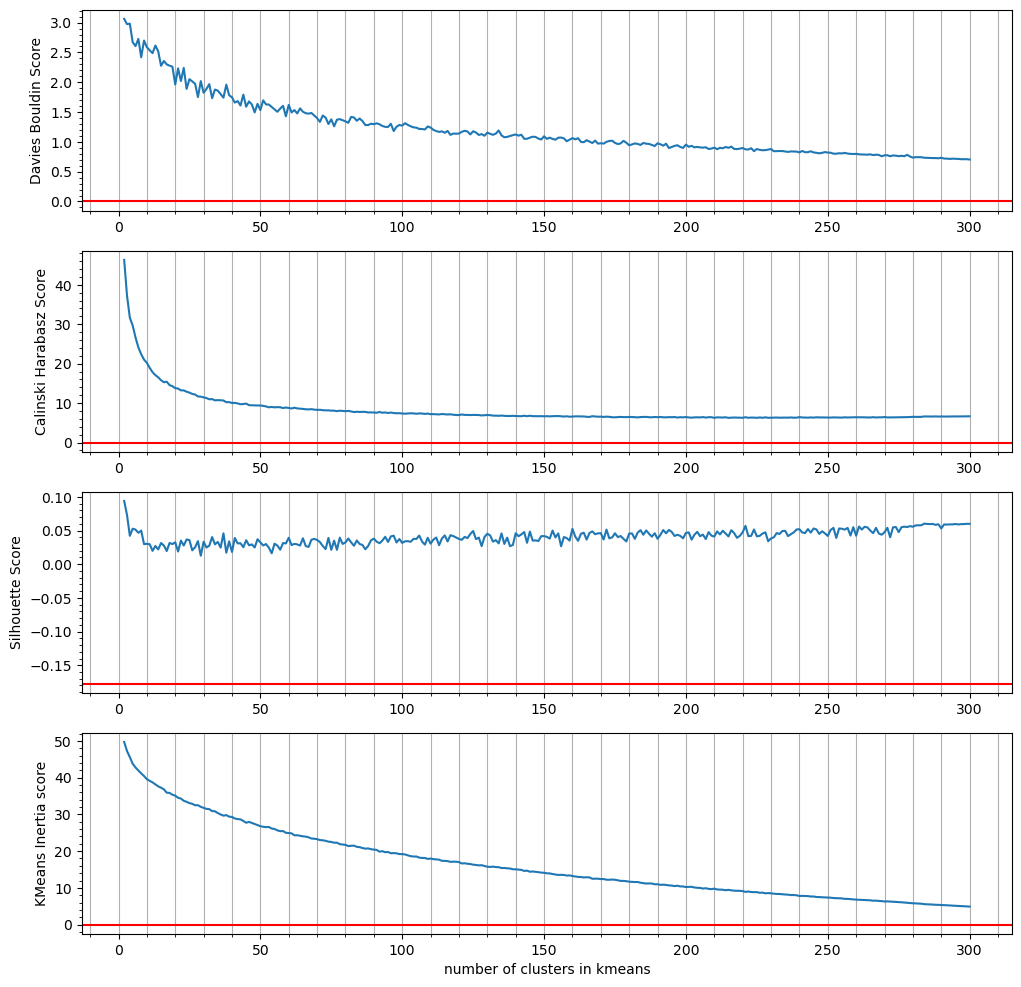

In [9]:
kmeansSP500.summarize(clusters_dict)

Doing analysis with: 2 clusters
Doing analysis with: 264 clusters


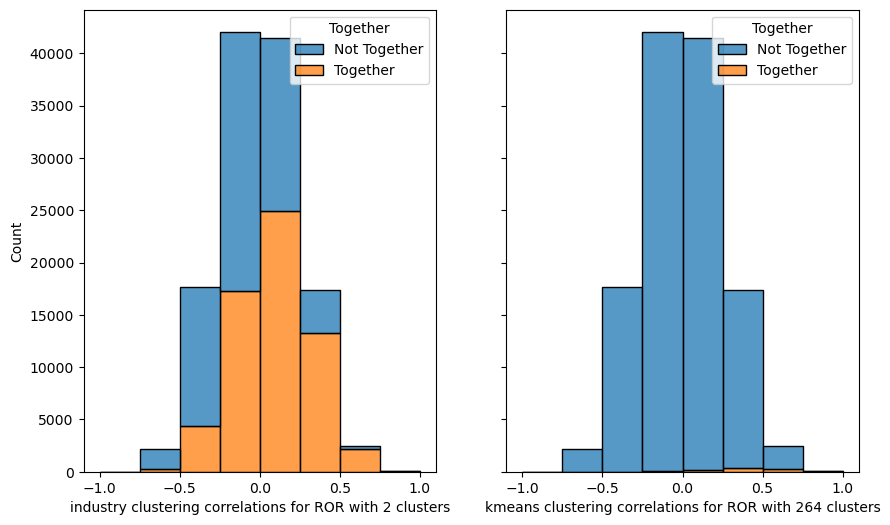

In [10]:
best_cluster_ind = np.argmax(kmeansSP500.scores['CalinskiHarabasz'])

cluster_dict = kmeansSP500.clusters[best_cluster_ind]
print(f"Doing analysis with: {best_cluster_ind+2} clusters")


f, axarr = plt.subplots(1,2, sharey = True, figsize=(10,6))
axarr[0].set_xlabel("industry clustering correlations for ROR with 2 clusters")
axarr[1].set_xlabel("kmeans clustering correlations for ROR with 264 clusters")


correlation_histogram(data, bins = np.linspace(-1,1,9), clusters = cluster_dict, ax = axarr[0])

best_cluster_ind = np.argmax(kmeansSP500.scores['Silhouette'][20:])
cluster_dict = kmeansSP500.clusters[best_cluster_ind]
print(f"Doing analysis with: {best_cluster_ind+2} clusters")


correlation_histogram(data, bins = np.linspace(-1,1,9), clusters = cluster_dict, ax = axarr[1])


In [11]:
X = data[-3:].T
clusters_dict =  kmeansSP500.clusters[0]
X["cluster"] = list(clusters_dict.values())
cols = X.columns
X[cols[2]]

Ticker
MMM     0.010308
AOS    -0.010716
ABT     0.022408
ABBV   -0.068046
ACN    -0.012170
          ...   
YUM    -0.062522
ZBRA   -0.006617
ZBH     0.027262
ZION    0.050572
ZTS     0.041269
Name: 2023-11-01 00:00:00-04:00, Length: 497, dtype: float64

<AxesSubplot:xlabel='2023-10-01 00:00:00-04:00', ylabel='2023-11-01 00:00:00-04:00'>

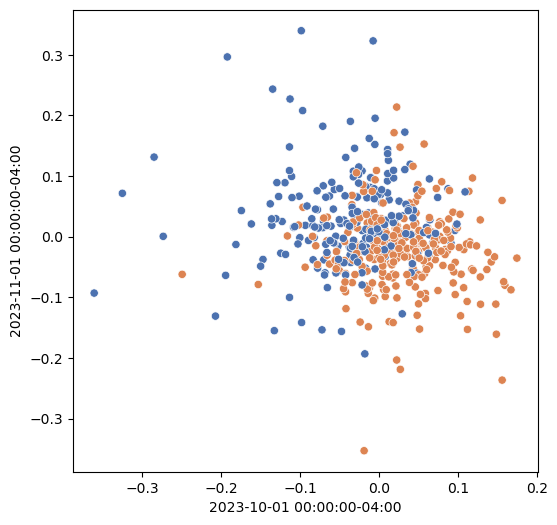

In [12]:

X = data[-2:].T
clusters_dict =  kmeansSP500.clusters[0]
X["cluster"] = list(clusters_dict.values())


cols = X.columns
f, ax = plt.subplots(figsize = (6,6))

sns.scatterplot(data = X, x = cols[0], y = cols[1], hue = 'cluster', palette = 'deep', ax = ax, legend = False)

In [13]:
import plotly.graph_objects as go

X = data[-4:].T
clusters_dict =  kmeansSP500.clusters[0]
X["cluster"] = list(clusters_dict.values())
cols = X.columns
fig = go.Figure(data = [go.Scatter3d(
    x = X[cols[0]],
    y = X[cols[1]],
    z = X[cols[2]],
    mode = 'markers',
    marker = dict(
        size = 4,
        color = X['cluster'],
        colorscale = 'spectral',
        opacity = 0.8
    )
)])

fig.update_layout(
    title = "3D visualization of clusters",
    scene = dict(
        xaxis_title = "returns 1",
        yaxis_title = "returns 2",
        zaxis_title = "returns 3"
    ),
    margin = dict(l = 0, r = 0, t= 0)
)

fig.show()

As we can see, Kmeans on its own cannot beat the baseline model of industry clustering for risk-adjusted returns, which are the most useful for financial modeling.

There are two possible alternate approaches. 
- The first is to cluster *within* each industry cluster, and to refine the industry clustering. 
- The second is to try to remove the influence of "industry" on the sharpe rates of return, and then to try clustering again.

# Clustering using Dendrograms

In [14]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

import datetime as dt
from concurrent import futures
import numpy as np
from scipy.stats import gaussian_kde
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, set_link_color_palette
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans


In [15]:
result = linkage(data.T.values, metric='cityblock', method='average')

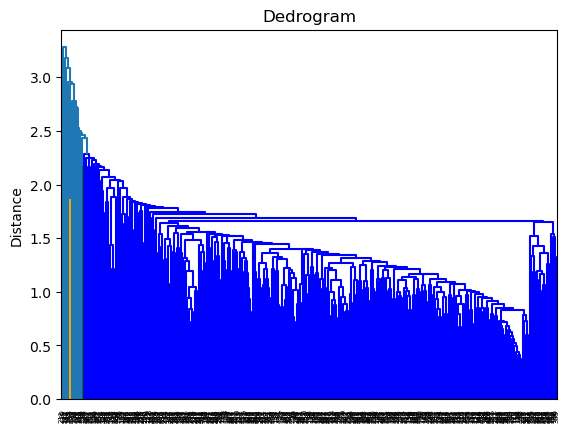

In [16]:
color_list = ["orange", "green", "blue"]
set_link_color_palette(color_list)
dendrogram(result)
plt.title("Dedrogram")
plt.ylabel("Distance")
plt.show()

# Clustering Using TSNE

c:\Users\safibn\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\safibn\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



(497, 2)


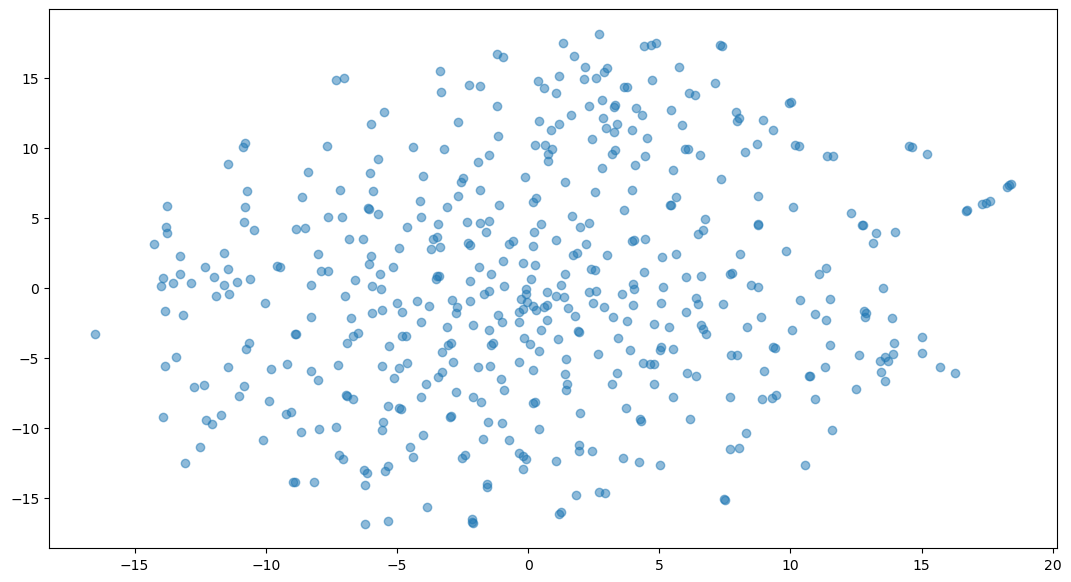

In [17]:
tsne = TSNE(n_components=2, random_state=0)
X_reduced = tsne.fit_transform(data.T)
print(X_reduced.shape)


plt.figure(figsize=(13, 7))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.5)
plt.show()


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, -1}


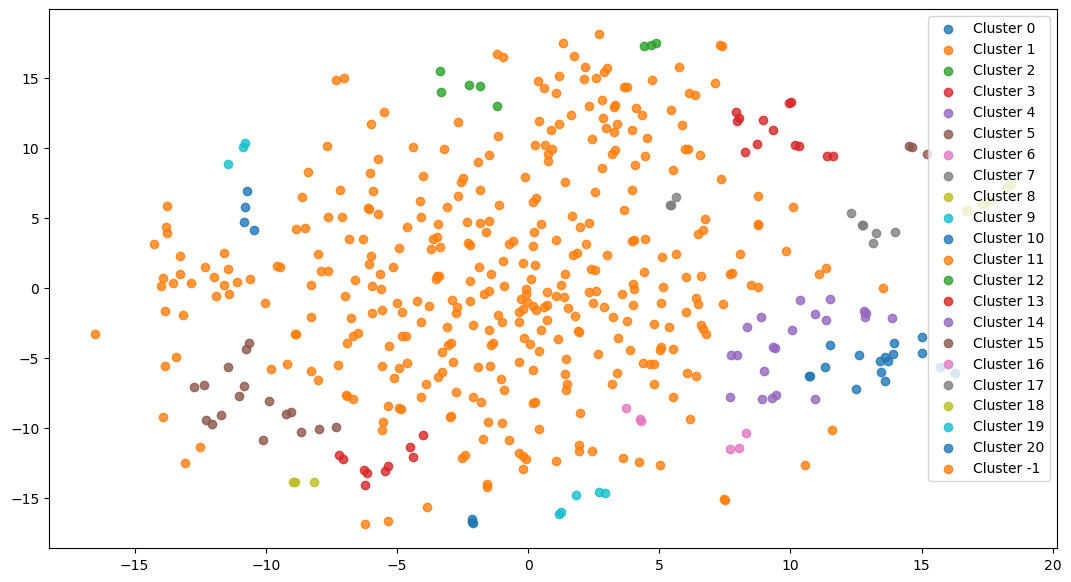

In [18]:
clustering = DBSCAN(eps=1.6, min_samples=3).fit(X_reduced)
labels_dbscan = clustering.labels_
print(set(labels_dbscan))

plt.figure(figsize=(13, 7))
for x in set(labels_dbscan):
    plt.scatter(X_reduced[labels_dbscan==x, 0], X_reduced[labels_dbscan==x, 1], alpha=0.8, label=f"Cluster {x}")
plt.legend()
plt.show()

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}


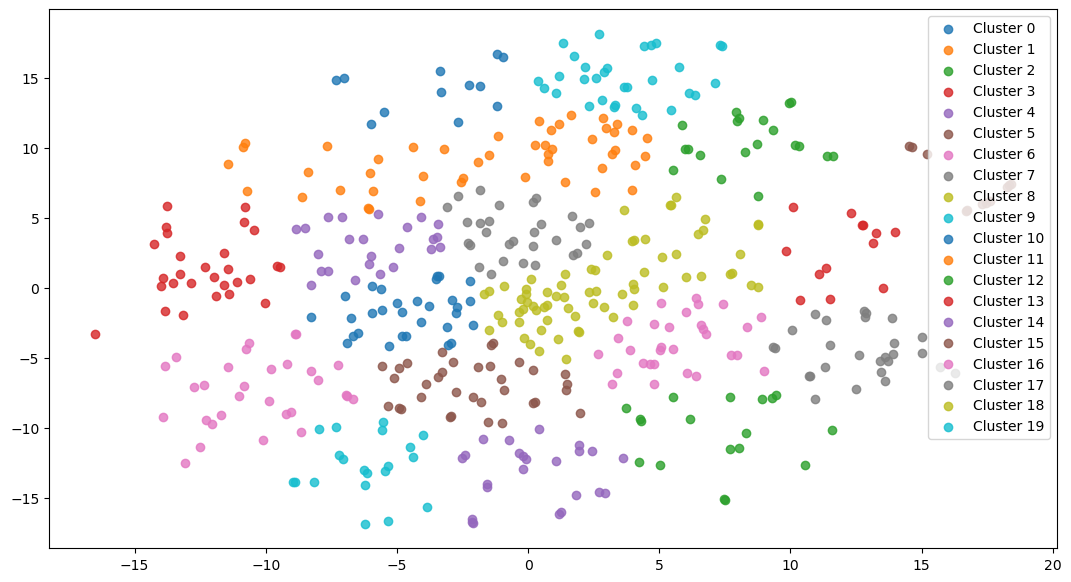

In [19]:
clustering = KMeans(n_clusters=20).fit(X_reduced)
labels_dbscan = clustering.labels_
print(set(labels_dbscan))

plt.figure(figsize=(13, 7))
for x in set(labels_dbscan):
    plt.scatter(X_reduced[labels_dbscan==x, 0], X_reduced[labels_dbscan==x, 1], alpha=0.8, label=f"Cluster {x}")
plt.legend()
plt.show()

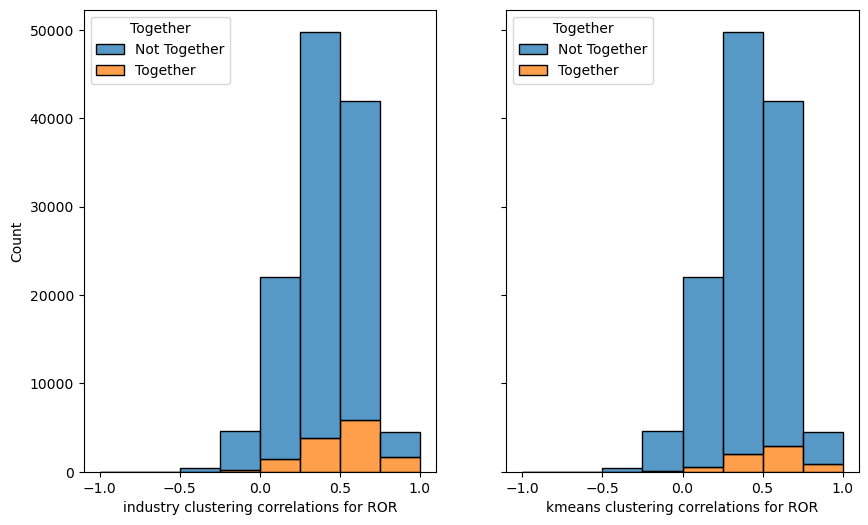

In [20]:
f, axarr = plt.subplots(1,2, sharey = True, figsize=(10,6))

axarr[0].set_xlabel("industry clustering correlations for ROR")
axarr[1].set_xlabel("kmeans clustering correlations for ROR")

correlation_histogram(ROR, bins = np.linspace(-1,1,9), clusters = industry_clusters, ax = axarr[0])

clusters = {tick : label for (tick, label) in zip(ROR.columns, labels_dbscan)}
correlation_histogram(ROR, bins = np.linspace(-1,1,9), clusters = {tick : label for (tick, label) in zip(ROR.columns, labels_dbscan)}, ax = axarr[1])

<AxesSubplot:xlabel='2022-01-01 00:00:00-05:00', ylabel='2022-02-01 00:00:00-05:00'>

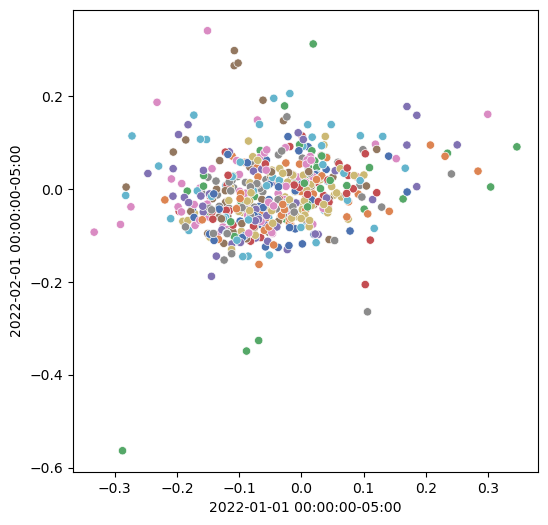

In [21]:
final_prices = ROR.T
final_prices["cluster"] = list(clusters.values())
cols = final_prices.columns
f, ax = plt.subplots(figsize = (6,6))

sns.scatterplot(data = final_prices, x = cols[0], y = cols[1], hue = 'cluster', palette = 'deep', ax = ax, legend = False)

# Embedding with Dynamic Time Warping and TSNE

In [81]:
import tslearn as ts
from tslearn.metrics import dtw, cdist_dtw
import pandas as pd

In [82]:
DTW = cdist_dtw(data.T)

In [83]:
tsne = TSNE(n_components=2, random_state=0)
X_reduced = tsne.fit_transform(DTW)
data_reduced = pd.DataFrame(X_reduced.T, columns = data.columns)
print(X_reduced.shape)

c:\Users\safibn\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\safibn\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



(497, 2)


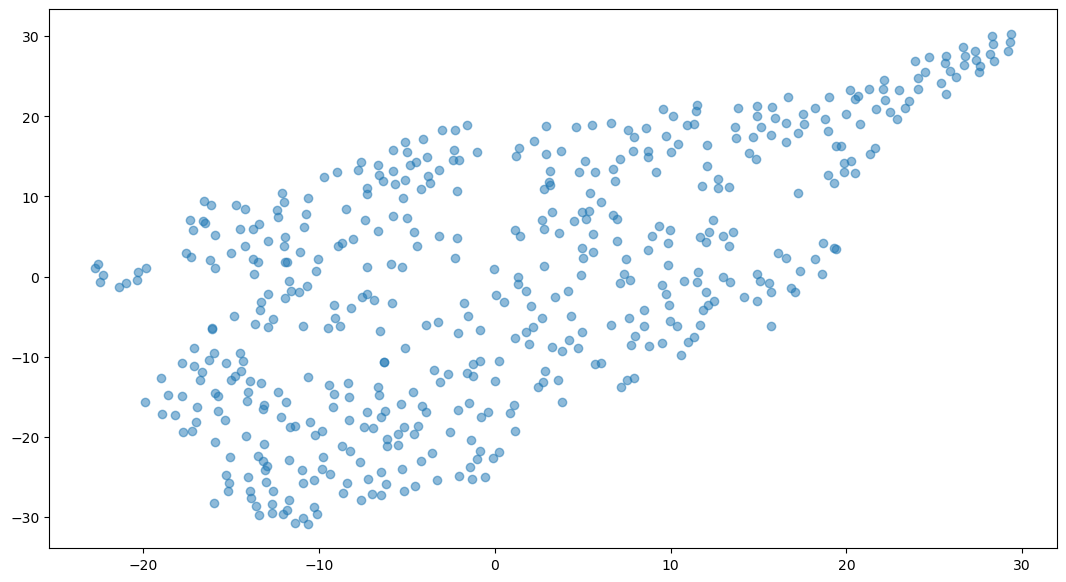

In [84]:
plt.figure(figsize=(13, 7))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.5)
plt.show()


In [26]:
kmeansSP500 = KMeans_Clustering_SP500(n_min = 2, 
                                      n_max = 300,
                                      use_validation = False)
kmeansSP500.fit(data_reduced)


Finished fitting... Go make some pictures bruh!


DB score for industry clusters: 27.218513835182907
CH score for industry clusters: 7.875138757664029
Sil score for industry clusters: -0.15521176159381866


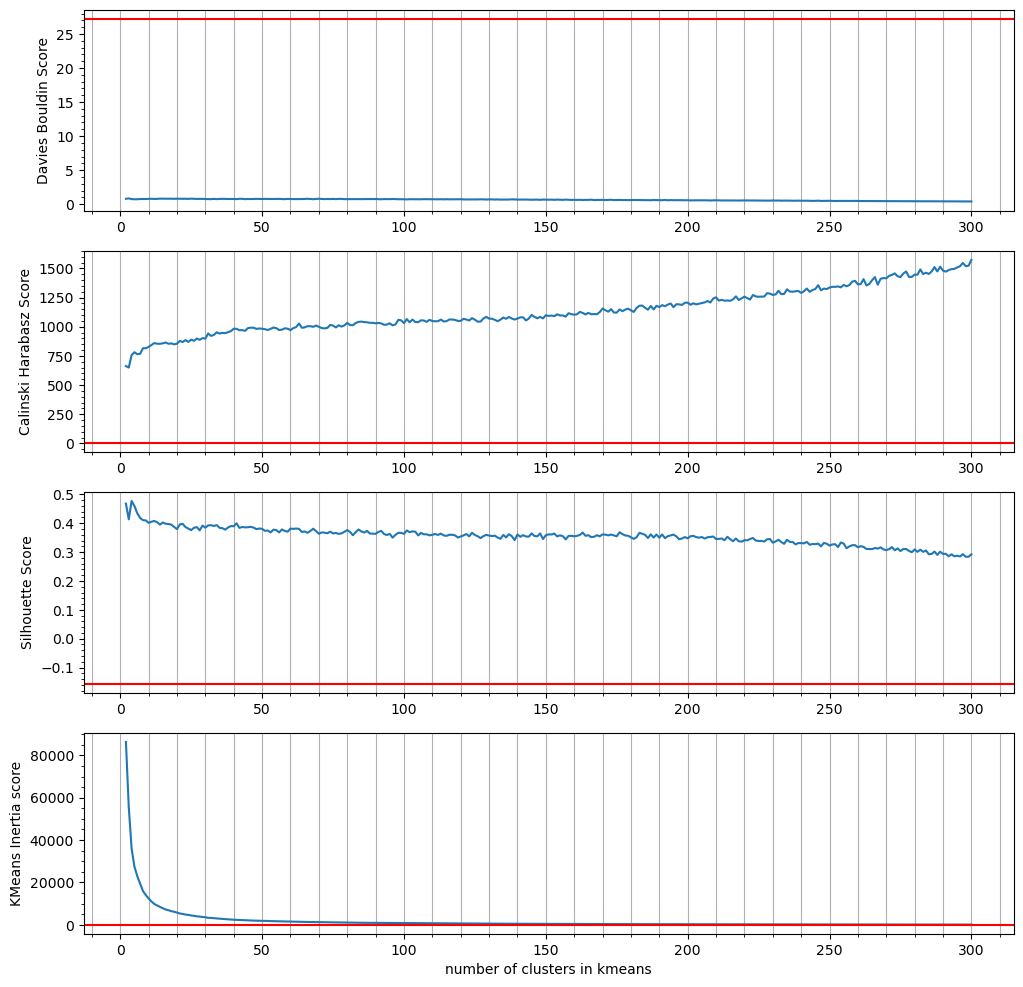

In [27]:
kmeansSP500.summarize(industry_clusters)

Doing analysis with: 300 clusters
Doing analysis with: 4 clusters
Doing analysis with: 12 clusters


Text(0.5, 0, 'Clustering correlations with 12 clusters')

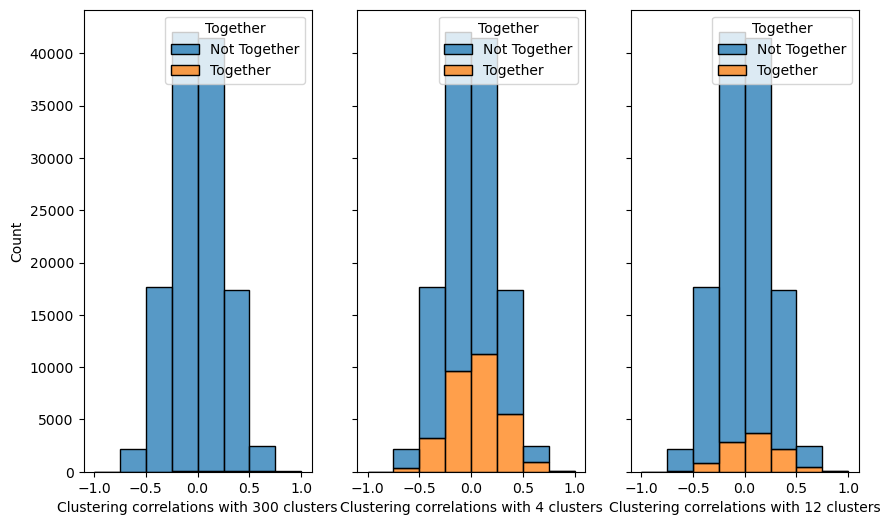

In [28]:
from data_pipeline.processing import correlation_histogram

best_cluster_ind = np.argmax(kmeansSP500.scores['CalinskiHarabasz'])
cluster_dict = kmeansSP500.clusters[best_cluster_ind]
print(f"Doing analysis with: {best_cluster_ind+2} clusters")


f, axarr = plt.subplots(1,3, sharey = True, figsize=(10,6))

correlation_histogram(data, bins = np.linspace(-1,1,9), clusters = cluster_dict, ax = axarr[0])
axarr[0].set_xlabel(f"Clustering correlations with {best_cluster_ind + 2} clusters")

best_cluster_ind = np.argmax(kmeansSP500.scores['Silhouette'])
cluster_dict = kmeansSP500.clusters[best_cluster_ind]
print(f"Doing analysis with: {best_cluster_ind+2} clusters")


correlation_histogram(data, bins = np.linspace(-1,1,9), clusters = cluster_dict, ax = axarr[1])
axarr[1].set_xlabel(f"Clustering correlations with {best_cluster_ind + 2} clusters")

best_cluster_ind = 10
cluster_dict = kmeansSP500.clusters[best_cluster_ind]
print(f"Doing analysis with: {best_cluster_ind+2} clusters")


correlation_histogram(data, bins = np.linspace(-1,1,9), clusters = cluster_dict, ax = axarr[2])
axarr[2].set_xlabel(f"Clustering correlations with {best_cluster_ind + 2} clusters")


Doing analysis with: 12 clusters


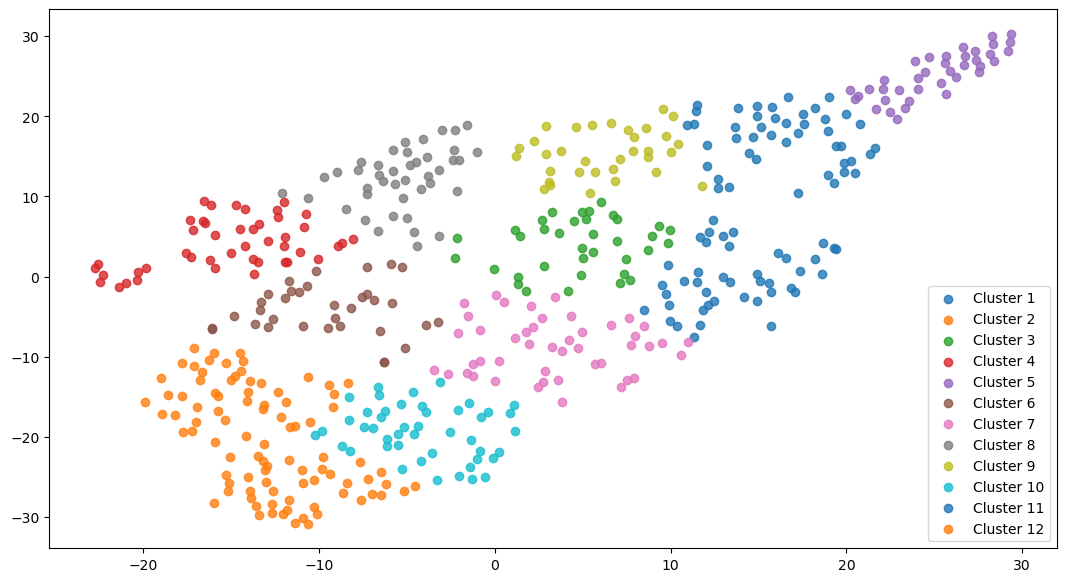

In [85]:
best_cluster_ind = 10
cluster_dict = kmeansSP500.clusters[best_cluster_ind]
print(f"Doing analysis with: {best_cluster_ind+2} clusters")

labels = list(cluster_dict.values())

plt.figure(figsize=(13, 7))
for x in set(labels):
    plt.scatter(data_reduced.iloc[0, labels==x], data_reduced.iloc[1, labels==x], alpha=0.8, label=f"Cluster {x+1}")
plt.legend()
plt.show()

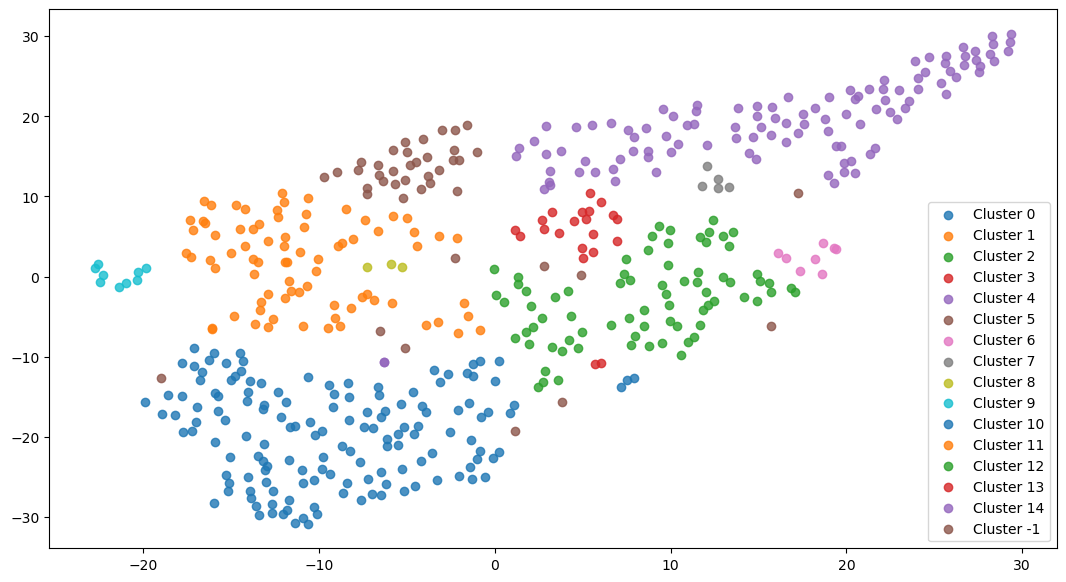

In [30]:
clustering = DBSCAN(eps=2, min_samples=2).fit(X_reduced)
labels_dbscan = clustering.labels_

cluster_dict = dict(zip(data_reduced, labels_dbscan))
labels = list(cluster_dict.values())

plt.figure(figsize=(13, 7))
for x in set(labels):
    plt.scatter(data_reduced.iloc[0, labels==x], data_reduced.iloc[1, labels==x], alpha=0.8, label=f"Cluster {x}")
plt.legend()
plt.show()


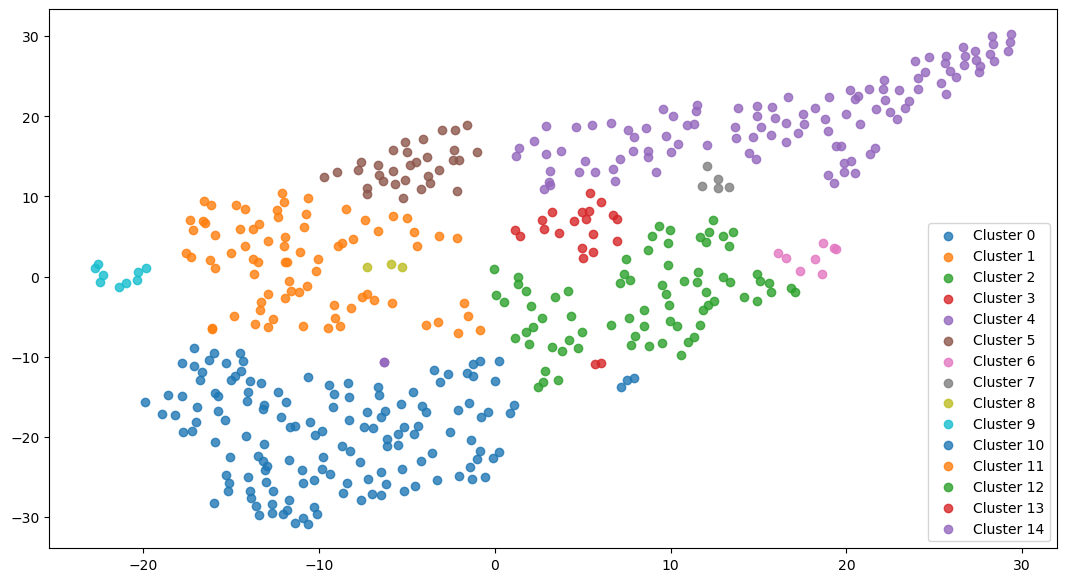

In [31]:
plt.figure(figsize=(13, 7))
for x in set(labels_dbscan):
    if x > -1:
        plt.scatter(data_reduced.iloc[0, labels_dbscan==x], data_reduced.iloc[1, labels_dbscan==x], alpha=0.8, label=f"Cluster {x}")
plt.legend()
plt.show()

In [86]:
CH_scores = []
for eps in np.linspace(0.1, 1, 1000):
    clustering = DBSCAN(eps=eps, min_samples=2).fit(X_reduced)
    labels_dbscan = clustering.labels_
    

    X_cleaned = X_reduced[labels_dbscan > -1, :]
    labels_cleaned = [l for l in labels_dbscan if l > -1]
    CH_scores.append(calinski_harabasz_score(X_cleaned, labels_cleaned))



Text(0, 0.5, 'Calinski-Harabasz Score')

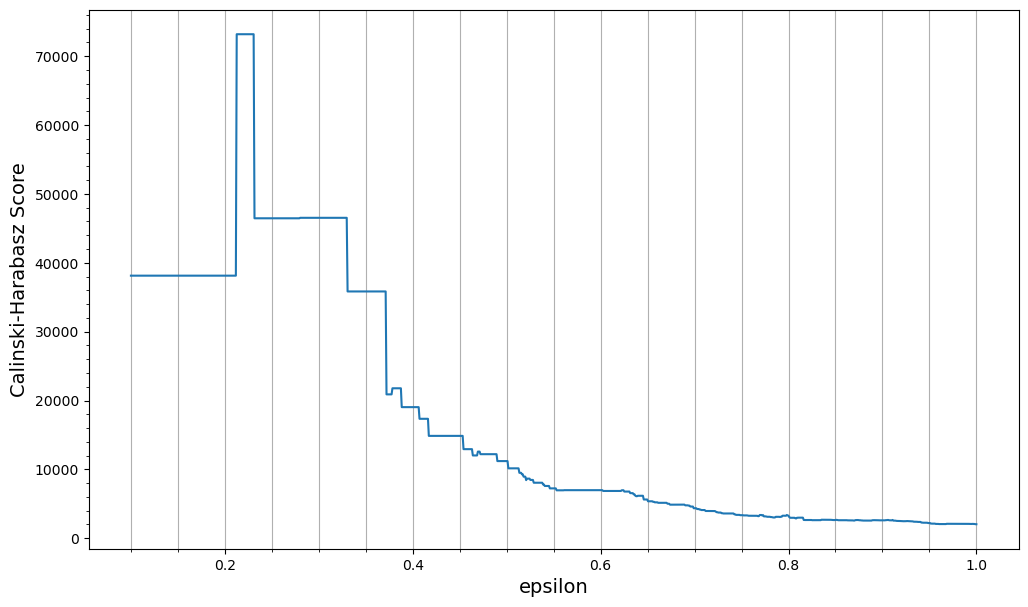

In [87]:
f, ax = plt.subplots(figsize = (12,7))

plt.plot(np.linspace(0.1,1,1000), CH_scores)
ax.grid('on', which='major', axis='x' )
ax.minorticks_on()
ax.grid('on', which='minor', axis='x' )
ax.set_xlabel("epsilon", fontsize = 14)
ax.set_ylabel("Calinski-Harabasz Score", fontsize = 14)

In [34]:

np.linspace(0.1,1,1000)[np.argmax(CH_scores)]


0.2126126126126126

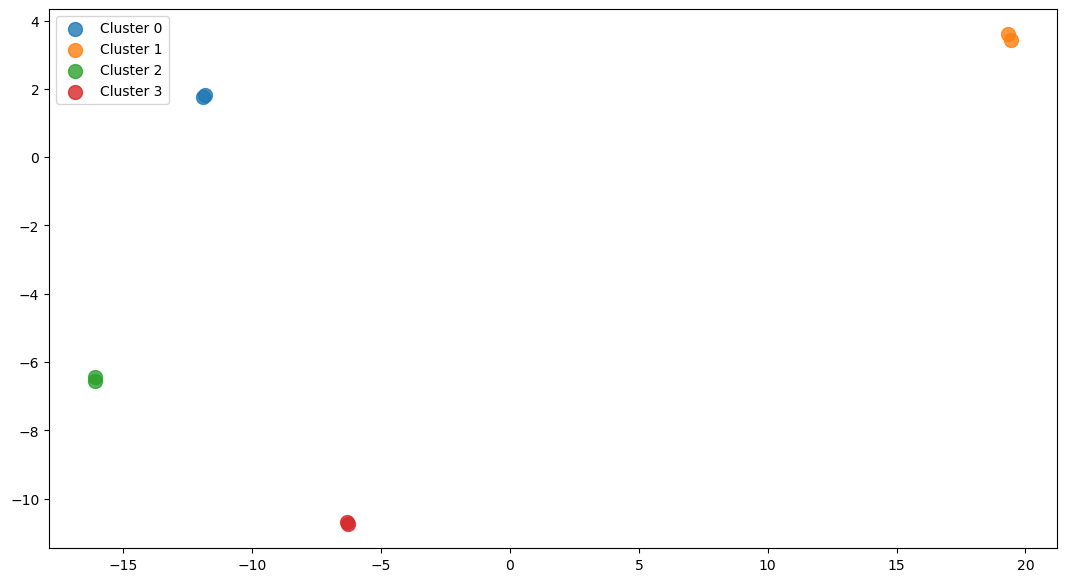

In [88]:
clustering = DBSCAN(eps=np.linspace(0.1,1,1000)[np.argmax(CH_scores)], min_samples=2).fit(data_reduced.values.T)
labels_dbscan = clustering.labels_

cluster_dict = dict(zip(data_reduced, labels_dbscan))
data_cleaned = data_reduced.iloc[:, labels_dbscan > -1]
labels_cleaned = [l for l in labels_dbscan if l > -1]

plt.figure(figsize=(13, 7))
for x in set(labels_cleaned):
    plt.scatter(data_cleaned.iloc[0, labels_cleaned==x], data_cleaned.iloc[1, labels_cleaned==x], alpha=0.8, label=f"Cluster {x}", s = 100)
plt.legend()
plt.show()

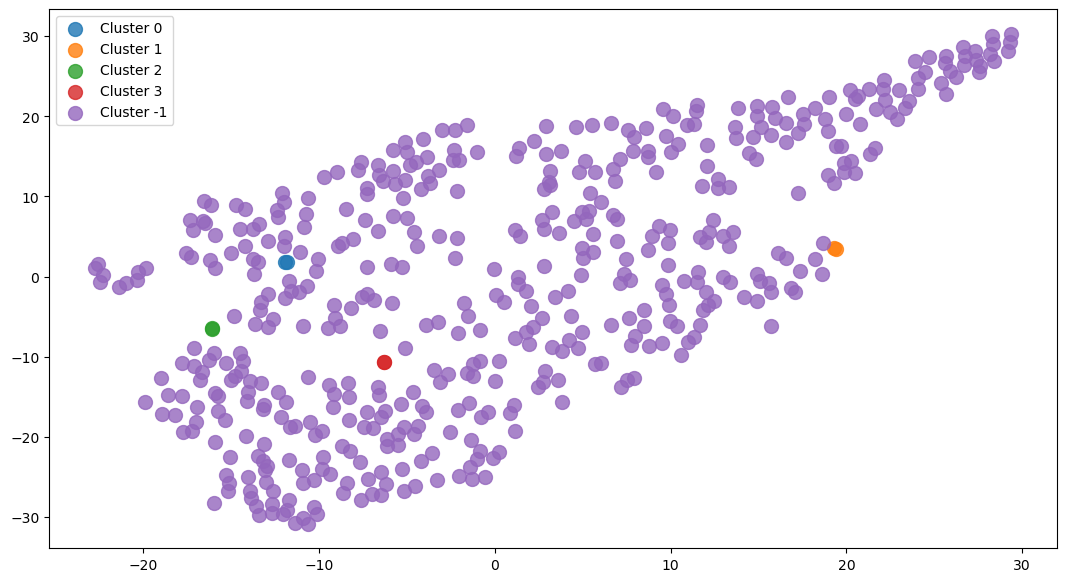

In [89]:
plt.figure(figsize=(13, 7))
for x in set(labels_dbscan):
    plt.scatter(data_reduced.iloc[0, labels_dbscan==x], data_reduced.iloc[1, labels_dbscan==x], alpha=0.8, label=f"Cluster {x}", s = 100)
plt.legend()
plt.show()

<AxesSubplot:xlabel='Date'>

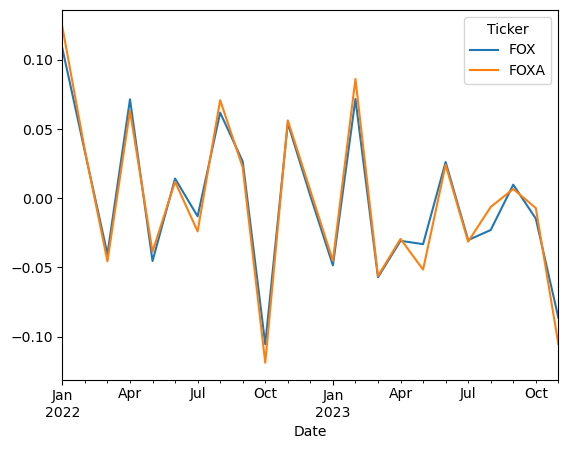

In [37]:
data[["FOX", "FOXA"]].plot()

<AxesSubplot:xlabel='Date'>

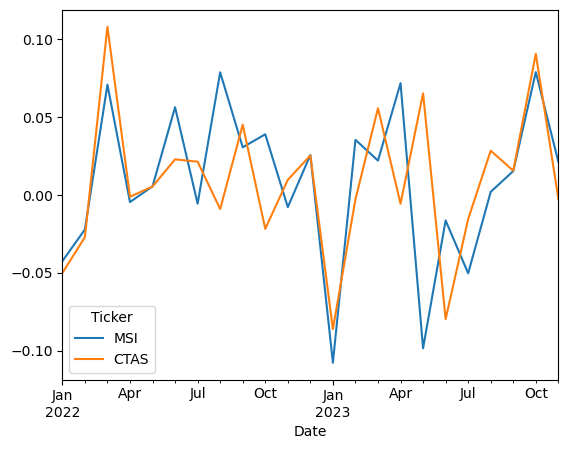

In [38]:
data[["MSI", "CTAS"]].plot()

# Trying again with a different random state

c:\Users\safibn\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\safibn\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



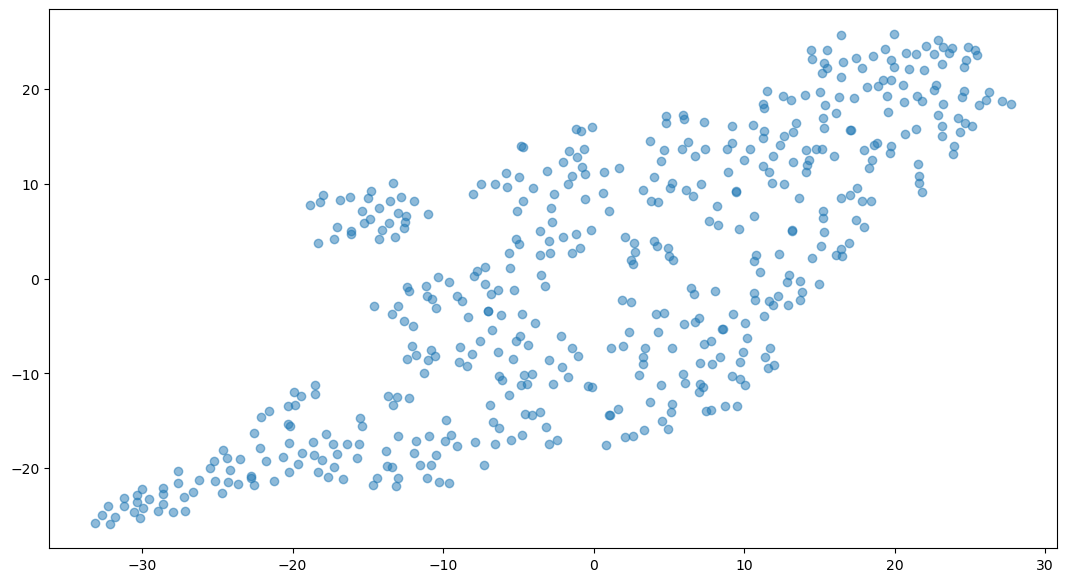

Text(0, 0.5, 'Calinski-Harabasz Score')

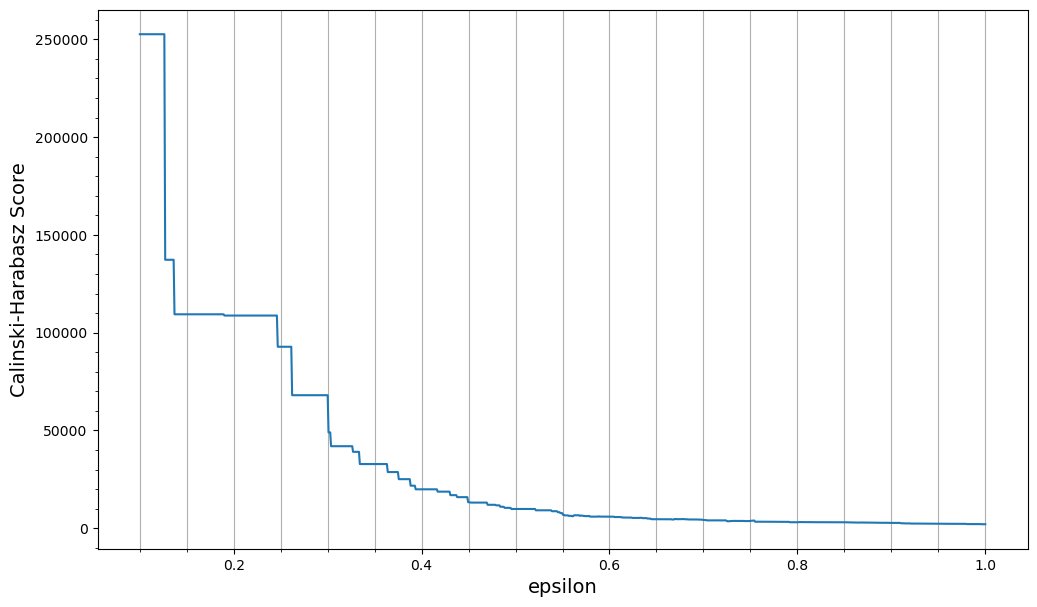

In [64]:
state = 420

tsne = TSNE(n_components=2, random_state=state)
X_reduced = tsne.fit_transform(DTW)
data_reduced = pd.DataFrame(X_reduced.T, columns = data.columns)

#X_reduced = tsne.fit_transform(data.T)

plt.figure(figsize=(13, 7))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.5)
plt.show()


CH_scores = []
for eps in np.linspace(0.1, 1, 1000):
    clustering = DBSCAN(eps=eps, min_samples=2).fit(X_reduced)
    labels_dbscan = clustering.labels_
    

    X_cleaned = X_reduced[labels_dbscan > -1, :]
    labels_cleaned = [l for l in labels_dbscan if l > -1]
    CH_scores.append(calinski_harabasz_score(X_cleaned, labels_cleaned))

f, ax = plt.subplots(figsize = (12,7))

plt.plot(np.linspace(0.1,1,1000), CH_scores)
ax.grid('on', which='major', axis='x' )
ax.minorticks_on()
ax.grid('on', which='minor', axis='x' )
ax.set_xlabel("epsilon", fontsize = 14)
ax.set_ylabel("Calinski-Harabasz Score", fontsize = 14)

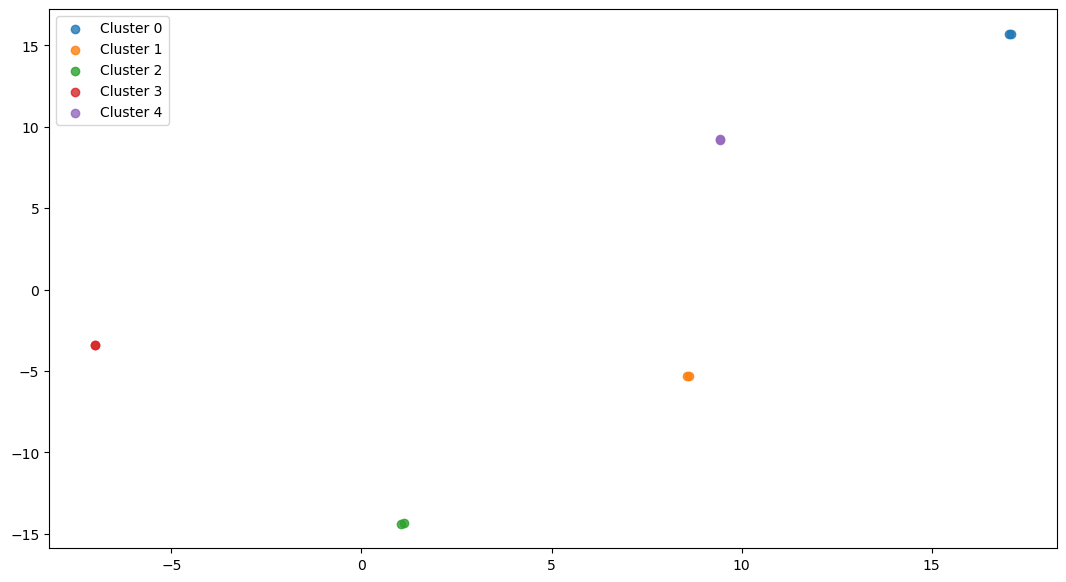

In [65]:
clustering = DBSCAN(eps=np.linspace(0.1,1,1000)[np.argmax(CH_scores)], min_samples=2).fit(data_reduced.values.T)
#clustering = DBSCAN(eps=0.3, min_samples=2).fit(data_reduced.values.T)

labels_dbscan = clustering.labels_

cluster_dict = dict(zip(data_reduced, labels_dbscan))
data_cleaned = data_reduced.iloc[:, labels_dbscan > -1]
labels_cleaned = [l for l in labels_dbscan if l > -1]

plt.figure(figsize=(13, 7))
for x in set(labels_cleaned):
    plt.scatter(data_cleaned.iloc[0, labels_cleaned==x], data_cleaned.iloc[1, labels_cleaned==x], alpha=0.8, label=f"Cluster {x}")
plt.legend()
plt.show()


In [66]:
data_cleaned

Ticker,ALLE,GOOGL,GOOG,APTV,KMB,MTB,NWSA,NWS,LUV,TRMB
0,17.044741,8.555660,8.617920,1.109717,17.082455,-7.000146,9.422482,9.437881,-7.012621,1.032629
1,15.677047,-5.324275,-5.334827,-14.367338,15.708323,-3.429636,9.230015,9.179351,-3.382142,-14.389512


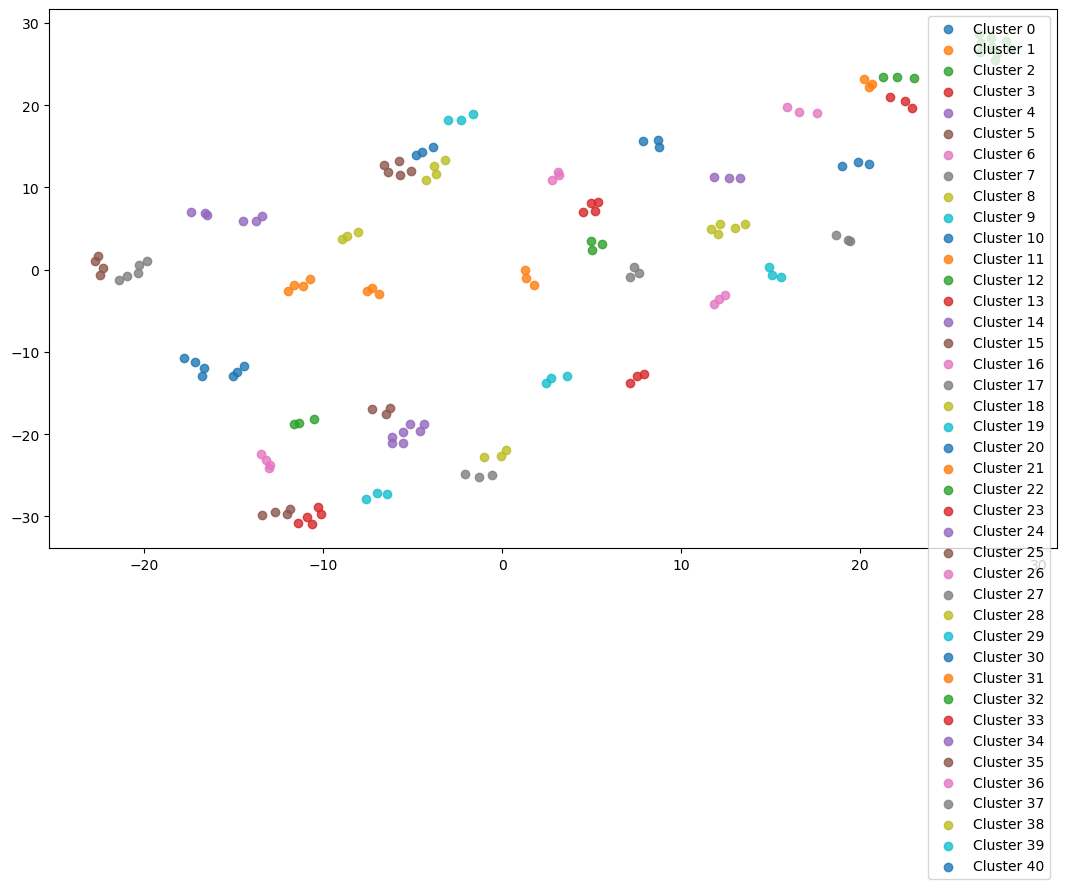

In [42]:
clustering = DBSCAN(eps=1, min_samples=3).fit(data_reduced.values.T)
#clustering = DBSCAN(eps=0.3, min_samples=2).fit(data_reduced.values.T)

labels_dbscan = clustering.labels_

cluster_dict = dict(zip(data_reduced, labels_dbscan))
data_cleaned = data_reduced.iloc[:, labels_dbscan > -1]
labels_cleaned = [l for l in labels_dbscan if l > -1]

plt.figure(figsize=(13, 7))
for x in set(labels_cleaned):
    plt.scatter(data_cleaned.iloc[0, labels_cleaned==x], data_cleaned.iloc[1, labels_cleaned==x], alpha=0.8, label=f"Cluster {x}")
plt.legend()
plt.show()

# Trying with just tSNE

c:\Users\safibn\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\safibn\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



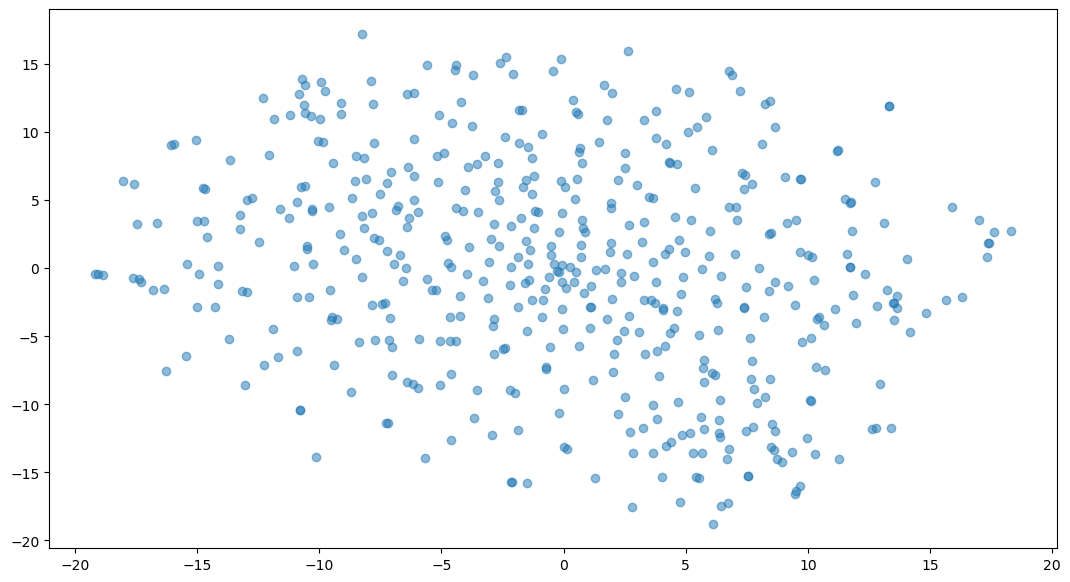

Text(0, 0.5, 'Calinski-Harabasz Score')

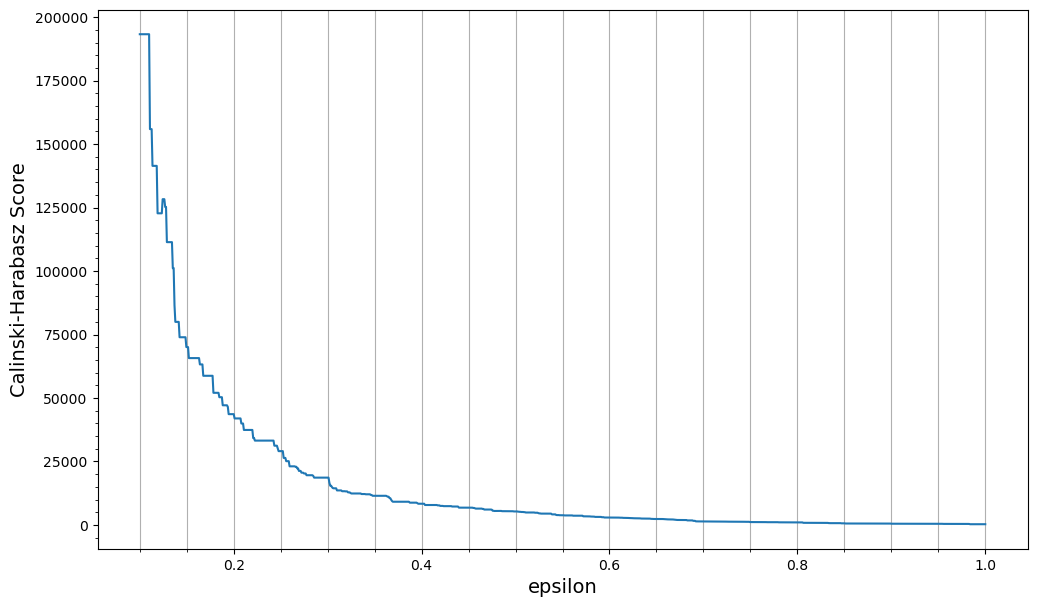

In [67]:
state = 420

tsne = TSNE(n_components=2, random_state=state)
X_reduced = tsne.fit_transform(data.T)
data_reduced = pd.DataFrame(X_reduced.T, columns = data.columns)

#X_reduced = tsne.fit_transform(data.T)

plt.figure(figsize=(13, 7))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.5)
plt.show()


CH_scores = []
for eps in np.linspace(0.1, 1, 1000):
    clustering = DBSCAN(eps=eps, min_samples=2).fit(X_reduced)
    labels_dbscan = clustering.labels_

    X_cleaned = X_reduced[labels_dbscan > -1, :]
    labels_cleaned = [l for l in labels_dbscan if l > -1]
    CH_scores.append(calinski_harabasz_score(X_cleaned, labels_cleaned))

f, ax = plt.subplots(figsize = (12,7))

plt.plot(np.linspace(0.1,1,1000), CH_scores)
ax.grid('on', which='major', axis='x' )
ax.minorticks_on()
ax.grid('on', which='minor', axis='x' )
ax.set_xlabel("epsilon", fontsize = 14)
ax.set_ylabel("Calinski-Harabasz Score", fontsize = 14)

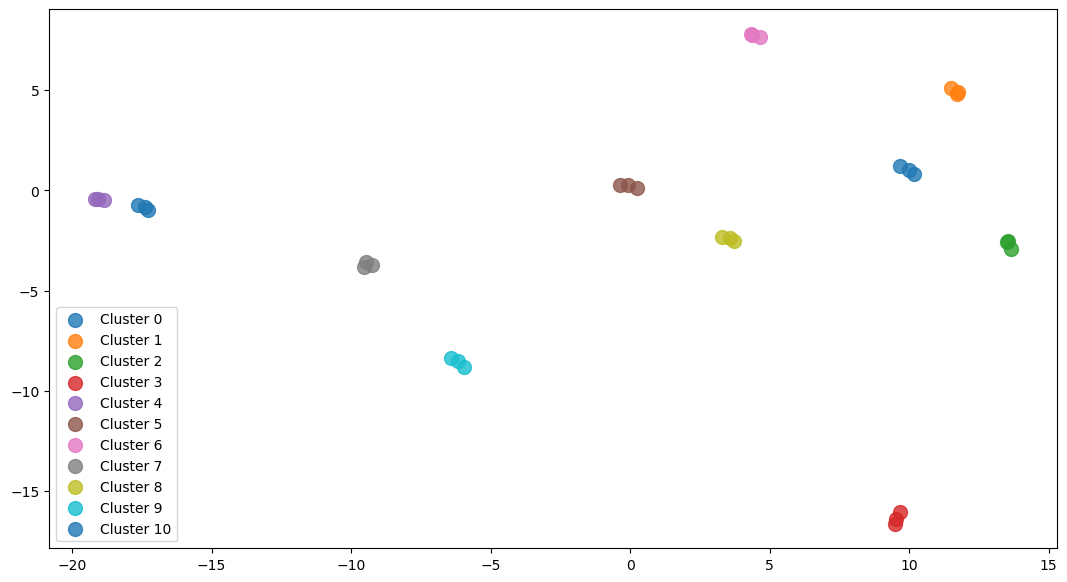

In [74]:
clustering = DBSCAN(eps=np.linspace(0.1,1,1000)[np.argmax(CH_scores)], min_samples=2).fit(data_reduced.values.T)
clustering = DBSCAN(eps=0.4, min_samples=3).fit(data_reduced.values.T)

labels_dbscan = clustering.labels_

cluster_dict = dict(zip(data_reduced, labels_dbscan))
data_cleaned = data_reduced.iloc[:, labels_dbscan > -1]
labels_cleaned = [l for l in labels_dbscan if l > -1]

plt.figure(figsize=(13, 7))
for x in set(labels_cleaned):
    plt.scatter(data_cleaned.iloc[0, labels_cleaned==x], data_cleaned.iloc[1, labels_cleaned==x], alpha=0.8, label=f"Cluster {x}", s = 100)
plt.legend()
plt.show()


In [71]:
np.linspace(0.1,1,1000)[np.argmax(CH_scores)]

0.1

In [70]:
data_cleaned

Ticker,ADP,GOOGL,GOOG,AEE,AEP,AMT,AON,ACGL,CSX,DHI,...,NSC,OMC,PAYX,SPGI,SBAC,TDY,TMO,VTR,WELL,WYNN
0,7.407795,11.723019,11.733357,-0.172982,-0.248124,11.757364,13.541914,7.539980,1.084876,11.216097,...,1.136020,-10.791243,7.386596,9.665169,11.718012,5.435270,4.361006,-7.258352,-7.199168,13.307759
1,-2.878852,0.126569,0.118095,-0.280634,-0.217358,4.880616,-2.549010,-15.280033,-2.817680,8.660366,...,-2.868268,-10.448432,-2.896185,6.569952,4.812412,-15.361296,7.762794,-11.381450,-11.357976,11.923056
